# Приоритезация гипотез и A/B-тестирование
Мы выступаем в роли аналитика крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.<br>

**Часть 1. Гипотезы.**<br>
В нашем распоряжении имеется таблица из 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Необходимо приоретизировать гипотезы по имеющимся параметрам и сделать выводы об актуальности.

**Часть 2. A/B-тестирование**<br>
После проведения A/B-теста были получены результаты, которые описаны в файлах `orders.csv` и `visitors.csv`. Необходимо изучить данные и сделать по результатам исследования выводы.

**Цели исследования:**<br>
1. Приоритезировать гипотезы методоми ICE и RICE, объяснить результаты;
2. Запустить A/B-тест, проанализировать его результаты и принять решение о продолжении теста.

**Задачи** исследования описаны далее для каждой части отдельно. 

## Импорт и изучение данных

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.3f}'.format) # Вывод трех знаков после запятой
pd.options.display.max_colwidth = 150 # Максимальная ширина столбца таблицы
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
import scipy.stats as stats

In [2]:
# Функция получения описания и первичной обработки датафрейма
def df_info(df):
    df.columns = map(str.lower, df.columns) # Приводим названия столбцов в нижний регистр
    display(df.head(5))
    df.info()
    print(f'Колиество полных дубликатов: {df.duplicated().sum()}')
    df = df.drop_duplicates()

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Таблица hypothesis

In [4]:
df_info(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Колиество полных дубликатов: 0


Описание данных:
* `hypothesis` — краткое описание гипотезы;
* `reach` — охват пользователей по 10-балльной шкале;
* `impact` — влияние на пользователей по 10-балльной шкале;
* `confidence` — уверенность в гипотезе по 10-балльной шкале;
* `efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 

### Таблица orders

In [5]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
df_info(orders)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
Колиество полных дубликатов: 0


Описание данных:
* `transaction_id` — идентификатор заказа;
* `visitor_id` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

### Таблица visitors

In [6]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
df_info(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
Колиество полных дубликатов: 0


* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## Часть 1. Приоритезация гипотез

**Задачи:**
* Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

### Расчет ICE
Сначала приоритезируем гипотезы методом ICE:

In [7]:
# Добавляем столбец 'ICE' и считаем значение для каждой гипотезы
hypothesis['ICE'] = (hypothesis['impact']
                     * hypothesis['confidence']
                     / hypothesis['efforts'])
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False))
print(f'Гипотезы в порядке приоритетности: {list(hypothesis[["hypothesis", "ICE"]].sort_values(by="ICE", ascending = False).index)}')

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Гипотезы в порядке приоритетности: [8, 0, 7, 6, 2, 1, 5, 3, 4]


Приоритезация гипотез методом ICE дала следующие результаты:<br>
* Самыми приоритетными оказались гипотезы под номерами **8**, **0** и **7**.
* Гипотеза **4** оказалась наименее приоритетной.<br>

Общий порядок: **8, 0, 7, 6, 2, 1, 5, 3, 4**.

### Расчет RICE
Далее приоритезируем гипотезы по методу RICE:

In [8]:
# Добавляем столбец 'RICE' и считаем значение для каждой гипотезы
hypothesis['RICE'] = (hypothesis['reach']
                     * hypothesis['impact']
                     * hypothesis['confidence']
                     / hypothesis['efforts'])
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending = False))
print(f'Гипотезы в порядке приоритетности: {list(hypothesis[["hypothesis", "RICE"]].sort_values(by="RICE", ascending = False).index)}')

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


Гипотезы в порядке приоритетности: [7, 2, 0, 6, 8, 3, 1, 5, 4]


При таком подходе результаты немного отличаются от предыдущих:<br>
* Самыми приоритетными гипотезами оказались **7**, **2** и **0**.
* Наименне приоритетной гипотезой осталась **4**.

Общий порядок: **7, 2, 0, 6, 8, 3, 1, 5, 4**.

### Анализ результатов
Учет охвата изменил приоритетность некоторых гипотез. Сравним их еще раз бок о бок:
* Метод **ICE**:  8, 0, 7, 6, 2, 1, 5, 3, 4
* Метод **RICE**: 7, 2, 0, 6, 8, 3, 1, 5, 4

Видно, что при расчете по методике **RICE** гипотезы **7**, **2** и **3** получили значительно более высокий приоритет, чем при методике **ICE** (+2-3 позиции). Гипотеза **8** же переместилась с первого на пятое место. Гипотеза под номером **4** в обоих случаях остается на последнем месте. Приоритет остальных гипотез не притерпел значительных изменений.<br>
Все различия связаны с тем, что метод **RICE** учитывает параметр охвата - размер группы пользователей, которых коснутся планируемые изменения. Гипотезы **7** и **2** имеют большие значения этого параметра, поэтому оказываются впереди. Гипотеза **8** имеет минимальное значение охвата, и из-за этого во втором случае оказывается наименее приоритетной задачей.

## Часть 2. Анализ A/B-теста
**Задачи:**
* Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
* Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
* Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения.
* Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
* Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выберать границу для определения аномальных пользователей.
* Построить точечный график стоимостей заказов. Сделать выводы и предположения.
* Посчитать 95-й и 99-й перцентили стоимости заказов. Выберать границу для определения аномальных заказов.
* Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
* Принять решение по результатам теста и объяснить его.

### Подготовка исходного датафрейма
Подготовим исходный датафрейм с кумулятивными значениями выручки и среднего чека для каждой группы:

In [9]:
# Cоздаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# Получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(
        orders['date'] <= x['date'], orders['group'] == x['group']
    )].agg(
        {'date' : 'max',
         'group' : 'max',
         'transaction_id' : 'nunique',
         'visitor_id' : 'nunique',
         'revenue' : 'sum'}
    ), axis=1).sort_values(by = ['date','group'])

# Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(
        visitors['date'] <= x['date'], visitors['group'] == x['group']
    )].agg(
        {'date' : 'max',
         'group' : 'max',
         'visitors' : 'sum'}
          ), axis=1).sort_values(by = ['date','group'])

# Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on = ['date', 'group'], right_on = ['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(6))

# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803


### Кумулятивная выручка

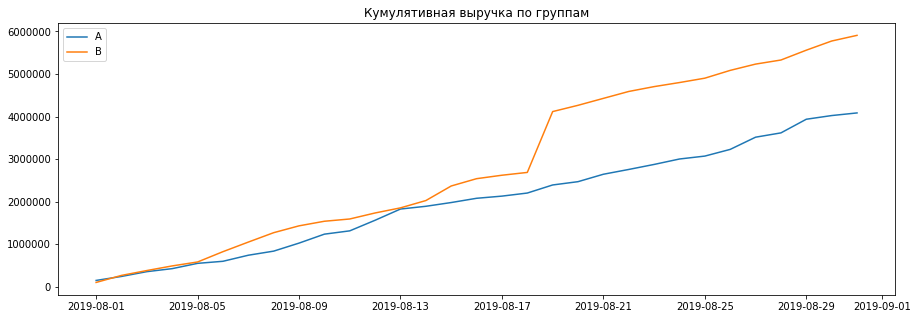

In [10]:
plt.figure(figsize = (15, 5))
plt.title('Кумулятивная выручка по группам')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

Выручка почти равномерно увеличивается в течение всего теста, это хороший знак.<br>
Однако график выручки **группы В** в одной точе резко растет. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

### Кумулятивный средний чек

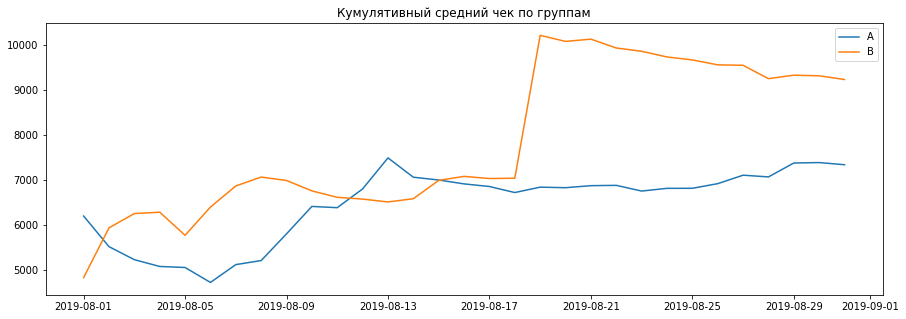

In [11]:
plt.figure(figsize = (15, 5))
plt.title('Кумулятивный средний чек по группам')

# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label = 'A')

# Строим график среднего чека группы В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label = 'B')

plt.legend()

Средний чек **группы В** также имеет резкий всплеск: скорее всего, в группу в попали крупные заказы. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне - видно, что после скачка линия постепенно снижеается. **Группа А**, похоже, пришла к реальному среднему чеку и установилась на его уровне.

### Оносительное изменение кумулятивного среднего чека групп

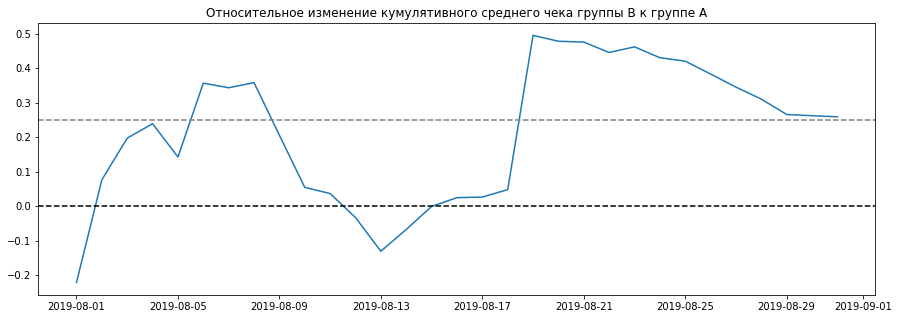

In [12]:
plt.figure(figsize = (15, 5))
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')

# Собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B']
)

# Строим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB'])
                                          / (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# Добавляем ось X
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.25, color = 'gray', linestyle = '--')

В нескольких точках график различия между сегментами резко "скачет". Очевидно, что в данных присутствуют анамально крупные заказы, меняющие таким образом общую картину. Далее определим такие заказы.

### Кумулятивная конверсия

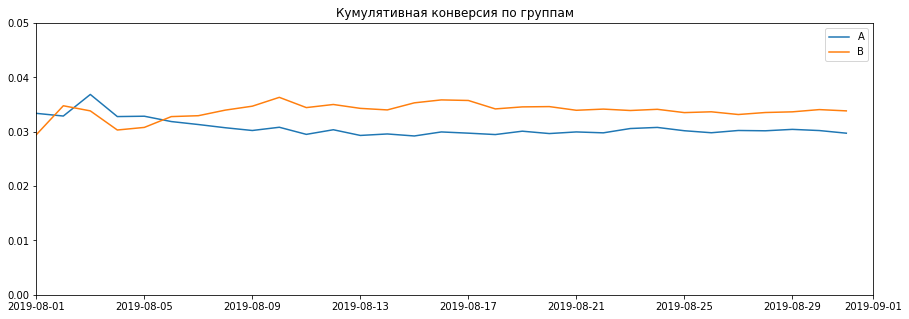

In [13]:
plt.figure(figsize = (15, 5))
plt.title('Кумулятивная конверсия по группам')

# Считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

#Оотделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

# Отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

# Cтроим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label = 'A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label = 'B')

plt.axis(["2019-08-01", '2019-09-01', 0, 0.05]) 
plt.legend()

Видим, что конверсия **группы B** стабилизировалась выше уровня конверсии **группы А**.<br>
Интересно, что там, где был резкий рост среднего чека (около 19.08.2019), мы наблюдаем небольшое падение конверсии - отсюда можно сделать вывод, что рост среднего чека был связан именно с аномально большими покупками в этот период.

### Относительное изменение кумулятивной конверсии групп

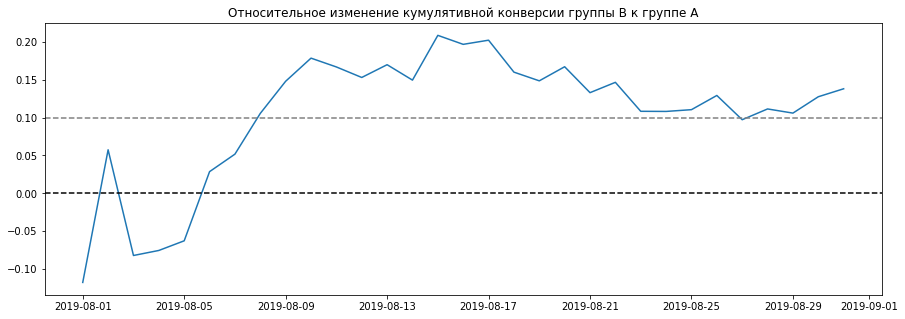

In [14]:
plt.figure(figsize = (15, 5))
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B']
)

plt.plot(mergedCumulativeConversions['date'], (mergedCumulativeConversions['conversionB'] 
                                              / mergedCumulativeConversions['conversionA'] - 1))

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

Из графика видно, что **группа В** практчески сразу вырвалась вперед по показателям конверсии.<br>
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии - возможно, они изменят картину.

### Количество заказов по пользователям

In [15]:
# Формируем таблицу с количеством заказов каждого пользователя
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['user_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head()

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


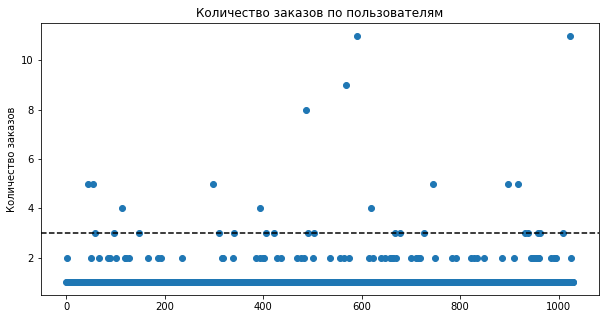

In [16]:
plt.figure(figsize = (10, 5))
plt.title('Количество заказов по пользователям')
plt.ylabel('Количество заказов')

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.axhline(y=3, color='black', linestyle='--')

Видим, что основная масса пользователей делает 1 заказ. Но много пользователей и с 2-3 заказами. Пока их точная доля не ясна — непонятно, считать их аномалиями или нет. Для определения посчитаем выборочные перцентили количества заказов на одного пользователя.

### Определение 95-й и 99-й перцентилей количества заказов на пользователя

In [17]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более **5%** пользователей оформляли более **двух** заказов, и не более **1%** пользователей оформляло более **четырех** заказов.<br>
Разумно выбрать **три** заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

### Cтоимость заказов

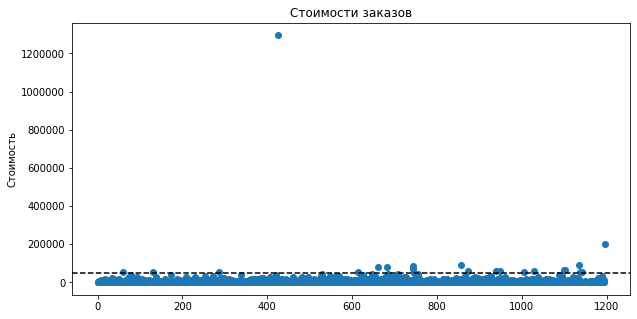

In [18]:
plt.figure(figsize = (10, 5))
plt.title('Стоимости заказов')
plt.ylabel('Стоимость')

x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']) 
plt.axhline(y=50000, color='black', linestyle='--')

Видим, что основная масса заказов находится в пределах **50000 рублей**. Но есть Значения, которые значительно больше этого показателя. Посчитаем процентили и определим границу аномалий.

### Определение 95-й и 99-й перцентилей стоимости заказов

In [19]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более **5%** заказов стоят дороже **28000** рублей, и не более **1%** заказов дороже **58233** рублей.<br>
Разумно выбрать стоимость заказа в **30000** рублей за нижнюю границу стоимости, и отсеять аномальные заказы по ней.

### Различия в "сырой" конверсии

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Обозначим гипотезы:
* H0: Конверсии в группах А и В равны.
* Н1: Конверсии в группах А и В отличаются.

Здесь и далее принимаем критерий значимости равным 5%.

In [20]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Создаем выборку пользователей из группы А
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Создаем выборку пользователей из группы В
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]

print(f'Результат теста: p-value = {"{0:.4f}".format(p_value)}')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")
    
print(f'Относительный прирост конверсии группы B: {"{0:.2f}".format((sampleB.mean() / sampleA.mean() - 1) * 100)}%')

Результат теста: p-value = 0.0084
Отвергаем нулевую гипотезу.
Относительный прирост конверсии группы B: 13.81%


P-value значительно меньше 0.05, потому нулевую гипотезу отвергаем. Анализ "сырых" данных сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы A равен **13.81%**.

### Различия в "сыром" среднем чеке

Посчитаем статистическую значимость различий суммы среднего чека между группами по «сырым» данным. Обозначим гипотезы:
* H0: Суммы среднего чека в группах А и В равны.
* Н1: Суммы среднего чека в группах А и В отличаются.

In [21]:
p_value = stats.mannwhitneyu(
    orders[orders['group']=='A']['revenue'],
    orders[orders['group']=='B']['revenue']
)[1]

print(f'Результат теста: p-value = {"{0:.4f}".format(p_value)}')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

print(f"Относительное увеличение среднего чека группы B: {'{0:.2f}'.format((orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1) * 100)}%")

Результат теста: p-value = 0.3646
Не получилось отвергнуть нулевую гипотезу.
Относительное увеличение среднего чека группы B: 25.87%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

### Выделение аномальных пользователей

In [22]:
# Выделяем пользователей с количеством заказов больше 3
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['user_id'],
    ],
    axis=0,
)

# Выделяем пользователей с заказами стоимостью более 30000 рублей
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']

# Соединяем аномальных пользователей в таблицу
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(f'Количество аномальных пользователей: {abnormalUsers.shape[0]}.')

Количество аномальных пользователей: 57.


По указанным критериям было отобрано 57 пользователей, что составляет около 5% от общего числа. Узнаем, как их действия повлияли на результаты теста.

### Различия в "чистой" конверсии

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Обозначим гипотезы:
* H0: Конверсии в очищенных группах А и В равны.
* Н1: Конверсии в очищенных группах А и В отличаются.

In [23]:
# Создаем очищенную выборку пользователей из группы А
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Создаем очищенную выборку пользователей из группы В
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

print(f'Результат теста: p-value = {"{0:.4f}".format(p_value)}')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")
    
print(f'Относительный прирост конверсии очищенной группы B: {"{0:.2f}".format((sampleBFiltered.mean() / sampleAFiltered.mean() - 1) * 100)}%')

Результат теста: p-value = 0.0092
Отвергаем нулевую гипотезу.
Относительный прирост конверсии очищенной группы B: 14.75%


Результаты по конверсии практически не изменились - гипотеза о равенстве конверсий в группах по прежнему отвергается.<br>
Процент относительного прироста конверсии очищенной группы B увеличился почти на **1%**.

### Различия в "чистом" среднем чеке

Посчитаем статистическую значимость различий суммы среднего чека между группами по «очищенным» данным. Обозначим гипотезы:

* H0: Суммы среднего чека в группах А и В равны.
* Н1: Суммы среднего чека в группах А и В отличаются.

In [24]:
p_value = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
          )[1]

delta = (orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1) * 100

print(f'Результат теста: p-value = {"{0:.4f}".format(p_value)}')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")
    
print(f'Относительный прирост конверсии очищенной группы B: {"{0:.2f}".format(delta)}%')

Результат теста: p-value = 0.4792
Не получилось отвергнуть нулевую гипотезу.
Относительный прирост конверсии очищенной группы B: -1.97%


P-value увеличился, но и разница между сегментами значительно сократилась с **25.87%** до **-1.97%**.

### Решение по результатам теста

Имеющиеся факты:
* Есть статистически значимое различие по конверсии между группами и по «сырым», и по данным после фильтрации аномалий.
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
* График различия среднего чека говорит о том, что результаты группы B лучше результатов группы А, но имеют тенденцию к ухудшению.
* График различия конверсии между группами сообщает, что результаты группы B также лучше результатов группы A и нет значительной тенденции к улучшению.

Исходя из обнаруженных фактов, на текущем этапе **следует прекратить тест** и зафиксировать **победу группы В**.